### Lexicon에 있는 키워드로 typography 이미지 실시간 크롤링

1. 텍스트 입력 시 LSTM 모델을 통해 emotion 예측
2. Lexicon에 기반하여 예측한 emotion과 유사한 단어를 랜덤으로 선택
3. 선택된 단어 + ['typography', 'typeface', 'font'] 중 랜덤 1개의 조합으로 구글 이미지 랜덤으로 서치
  
  *LSTM모델 모듈화 필요*

In [37]:
### import packages ###
import random
import numpy as np
import pandas as pd

import time
import requests
from io import BytesIO
from PIL import Image
from selenium import webdriver
from bs4 import BeautifulSoup as bs

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings(action='ignore')

In [66]:
### data load ###
path = "C:/Users/ASUX/Desktop/컨퍼런스/Lexicon_Image/Lexicon_data.txt"
data = pd.read_csv(path, names=["word", "emotion", "association"], sep='\t')
data.emotion.replace('trust', 'no emotion', inplace=True) # trust → no emotion / anticipation, negative, positive not used
data.head()

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [39]:
def get_url(driver, text):
    
    # Lexicon word choice
    sent_to_emotion = {0:'anger', 1:'disgust', 2:'fear', 3:'joy', 4:'sadness', 5:'surprise', 6:'no emotion'}
    
    global search, emo, t
    search = pd.Series(np.argmax(np.round(text))).map(sent_to_emotion).to_list()[0]
    emo = random.choice(data[(data.association == 1) & (data.emotion == search)].word.to_list())
    t = random.choice(['typography', 'typeface', 'font'])
    
    # get url
    url = "https://www.google.co.kr/search?q=" + str(emo) + " " + str(t)
    driver.get(url)
    driver.find_element_by_class_name('hide-focus-ring').click()
    time.sleep(3)
    
    html = driver.page_source
    soup = bs(html, 'lxml')

In [40]:
def scroll(driver, scroll_num):
    for i in range(scroll_num):
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        time.sleep(2)
        
    driver.execute_script('window.scrollTo(0,0);')

In [41]:
def crawl(driver, crawl_num, emotion, text):
    
    n = random.choice(list(range(crawl_num)))
    
    driver.find_elements_by_css_selector(".bRMDJf.islir")[n].click()
    time.sleep(1)
    
    try:
        img_url = driver.find_elements_by_class_name('n3VNCb')[1].get_property('src')
        res = requests.get(img_url)
        global img
        img = Image.open(BytesIO(res.content))
        
    except:
        crawl(driver, CRAWLING_NUM, emo, t)

텍스트를 영어로 입력하세요: I love you
해당 텍스트의 감정은 joy 입니다.


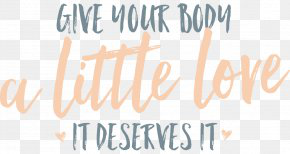

In [67]:
### searching ###
token = Tokenizer()
model = keras.models.load_model("C:/Users/ASUX/Desktop/컨퍼런스/Lexicon_Image/model.h5") # 모델 불러오기
path = 'C:/Users/ASUX/Desktop/chromedriver_win32/chromedriver' # 크롬드라이버 위치
SCROLL_NUM = 1 # 스크롤 횟수
CRAWLING_NUM = 30 # 몇 개의 이미지 중에서 선택할 지 결정

text = []
text.append(str(input("텍스트를 영어로 입력하세요: ")))
token.fit_on_texts(text)
text_pre = pad_sequences(token.texts_to_sequences(text), padding='pre', maxlen=200)
pre = model.predict(text_pre)

driver = webdriver.Chrome(path)
driver.maximize_window()
driver.get('https://www.google.co.kr/')
time.sleep(1)
get_url(driver, pre)
time.sleep(1)
#scroll(driver, SCROLL_NUM)
#time.sleep(1.5)
crawl(driver, CRAWLING_NUM, emo, t)

print("해당 텍스트의 감정은 " + search + " 입니다.")
img